In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, chi2
from category_encoders.target_encoder import TargetEncoder, OrdinalEncoder
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

In [21]:
X = pd.read_csv('Training_Dataset.csv')

In [22]:
y = pd.read_csv('Labels.csv')

In [23]:
# Delete useless features told by Shirish
X.drop(['Package_Name', 'SHA256', 'ThumbPrint', 'Application_Category', 
        'Family_Name', 'Malware_Category', 'Malware/Benign', 'label'], axis = 1, inplace = True)

## Feature Exploration

#### Find the one-hot features having missing values

In [24]:
X.describe().loc['count'][X.describe().loc['count'] < 10954]

sdkVersion          0.0
targetSdkVersion    0.0
Name: count, dtype: float64

In [25]:
# Delete these useless features (100% missing values)
X = X.drop(['sdkVersion', 'targetSdkVersion'], axis = 1)

In [26]:
# Check if there's no onehot feature has missing values
X.describe().loc['count'][X.describe().loc['count'] < 10954]

Series([], Name: count, dtype: float64)

#### Remove features with 0 variance

In [27]:
X.max()[X.max() == 0].index.to_list()

['Permission: REQUEST_DELETE_PACKAGES',
 'Permission: BIND_MIDI_DEVICE_SERVICE',
 'Permission: BIND_TV_INPUT',
 'Permission: com.android.voicemail.permission.ADD_VOICEMAIL',
 'Permission: com.android.launcher.permission.UNINSTALL_SHORTCUT',
 'Permission: READ_PHONE_NUMBERS',
 'Permission: GET_ACCOUNTS_PRIVILEGED',
 'Permission: REQUEST_COMPANION_RUN_IN_BACKGROUND',
 'Permission: ANSWER_PHONE_CALLS',
 'Permission: BIND_CARRIER_SERVICES',
 'Permission: REQUEST_IGNORE_BATTERY_OPTIMIZATIONS',
 'Permission: ACCESS_NOTIFICATION_POLICY',
 'Permission: com.android.voicemail.permission.READ_VOICEMAIL',
 'Permission: BODY_SENSORS',
 'Permission: BIND_SCREENING_SERVICE',
 'Permission: REQUEST_COMPANION_USE_DATA_IN_BACKGROUND',
 'Permission: BIND_TELECOM_CONNECTION_SERVICE',
 'Permission: BIND_VOICE_INTERACTION',
 'Permission: BIND_CHOOSER_TARGET_SERVICE',
 'Permission: com.android.launcher.permission.INSTALL_SHORTCUT',
 'Permission: BIND_AUTOFILL_SERVICE',
 'Permission: USE_FINGERPRINT',
 'Permis

In [28]:
X.drop(X.max()[X.max() == 0].index.to_list(), axis = 1, inplace = True)

## Feature Summary:


### Original Dataset:

#### (1) Missing Values:
   + Features with 100% missing values: 'sdkVersion', 'targetSdkVersion' (deleted)


#### (2) Features with 0 Variance:
  + Number of Features with 0 Variance: 511 (deleted)


### Preprocessed Dataset:

#### (1) Categories of Features:
  + Number of one-hot features: 352
 
 
#### (2) Features Extracted by Us
  + Number of featuers extracted by us (sensors): 29

In [29]:
chi_2, p = chi2(X, y)

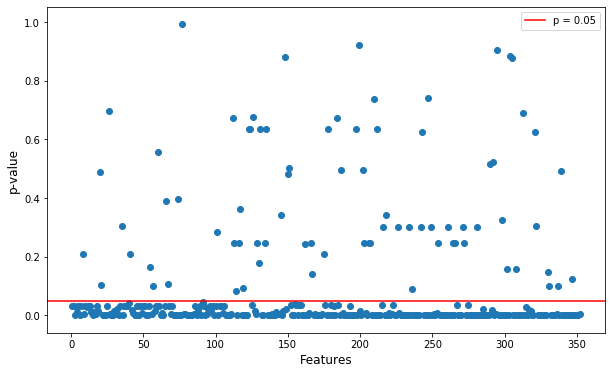

In [30]:
plt.figure(figsize = (10, 6))
plt.scatter(np.arange(1, 353), p)
plt.axhline(y=0.05, color='r', linestyle='-', label = 'p = 0.05')
plt.xlabel('Features', fontsize = 12)
plt.ylabel('p-value', fontsize = 12)
plt.legend()

## Building Pipelines

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 123, 
                                                    stratify = y)

In [32]:
continuous = make_column_selector(dtype_exclude = 'object')

pipe = make_pipeline(SimpleImputer(), SelectKBest(k=100, score_func=chi2), LogisticRegression(max_iter = 1000))

In [33]:
avg_val_score = np.mean(cross_val_score(pipe, X_train, np.squeeze(y_train.to_numpy().reshape(1, -1)), cv = 5))
print('The mean test score of Logistic Regression model is:', avg_val_score)

The mean test score of Logistic Regression model is: 0.871733193195227


In [34]:
pipe.fit(X_train, np.squeeze(y_train.to_numpy().reshape(1, -1)))

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('selectkbest',
                 SelectKBest(k=100,
                             score_func=<function chi2 at 0x7ff5d5b97b00>)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [35]:
y_pred = pipe.predict(X_test)

In [36]:
confusion_matrix(np.squeeze(y_test.to_numpy().reshape(1, -1)), y_pred)

array([[ 187,  214],
       [  67, 1723]])

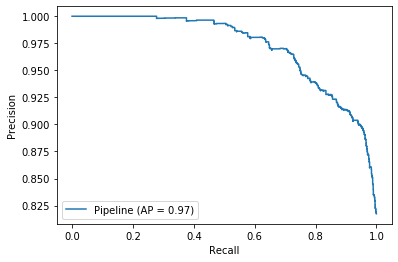

In [40]:
plot_precision_recall_curve(pipe, X_test, y_test)